## Chapter3.6 주택 가격 예측: 회귀 문제

### import boston data set

In [1]:
from keras.datasets import boston_housing

Using TensorFlow backend.


#### data split

In [4]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

### 데이터 준비

#### 데이터 표준화(스케일링)

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

# train의 평균, 표준편차를 사용
test_data -= mean
test_data /= std



In [10]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
             input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model
    
    

### K-FOLD 

In [12]:
import numpy as np

k = 4
num_val_samples = len(train_data) // 4
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
    axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [13]:
all_scores

[2.198058044556344, 2.126798150563004, 2.8552196521570186, 2.386943005099155]

#### 각 FOLD 검증 점수를 로그에 저장하기

In [14]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
    axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
             validation_data=(val_data, val_targets),
             epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [17]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]
average_mae_history

[4.7957879977651166,
 3.386863285952275,
 3.060000748917608,
 2.7478334797490938,
 2.7999082402427597,
 2.700780245337156,
 2.638163644488495,
 2.631128993364844,
 2.5631845139040803,
 2.5931169467397255,
 2.493584661200495,
 2.7374096577710447,
 2.5221513568764866,
 2.4063671933542383,
 2.4378363248145227,
 2.42471715955451,
 2.4888251441540103,
 2.4415354539852334,
 2.3791384035998053,
 2.507551654730693,
 2.396564451774748,
 2.359192425661748,
 2.3348321300922055,
 2.358023708409602,
 2.51855469104087,
 2.3484996486418317,
 2.310182002511355,
 2.4207627973934214,
 2.33783886751326,
 2.4663973362138956,
 2.3762558922909274,
 2.4938348260256324,
 2.350990549172505,
 2.463572274340261,
 2.431078627558038,
 2.3002445414514825,
 2.4008718681807566,
 2.3423248080924,
 2.318003407799371,
 2.3922305006792053,
 2.2838131271966615,
 2.3143598053715015,
 2.3034544463204867,
 2.290478351092575,
 2.2312845935915955,
 2.507109620783589,
 2.319332695243382,
 2.3416943361263463,
 2.34298582596354,


### 검증 점수 그래프

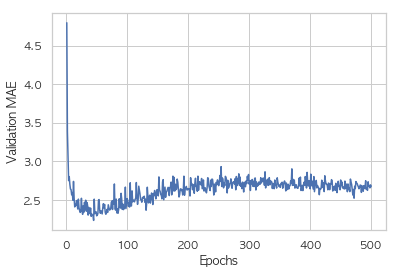

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#### Smooting

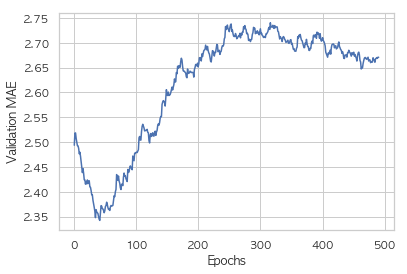

In [32]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1- factor))
        else:
            smoothed_points.append(point)
    
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### 최종 모델 훈련

In [34]:
model = build_model()
model.fit(train_data, train_targets,
         epochs=80, batch_size=16, verbose=0)
test_mse_scroe, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 697us/step


In [35]:
test_mse_scroe

18.186740950042125

In [36]:
test_mae_score

2.6853459676106772